# Dynamic Time Warping

## Files and Data
#### ground-truth folder
Contains ground truth data.


#### transcription.txt  
- XXX-YY-ZZ: XXX = Document Number, YY = Line Number, ZZ = Word Number
- Contains the character-wise transcription of the word (letters seperated with dashes)
- Special characters denoted with s_
	- numbers (s_x)
	- punctuation (s_pt, s_cm, ...)
	- strong s (s_s)
	- hyphen (s_mi)
	- semicolon (s_sq)
	- apostrophe (s_qt)
	- colon (s_qo)
    
### Task
Three files:  
##### training and test data:
train.txt, valid.txt
both contain a list of documents
##### keywords that are at least once in the training and validation set defined by train.txt and valid.txt
keywords.txt

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
from dtaidistance import dtw
import cv2
import time
import os
import helpers
import pandas as pd
import math

In [2]:
###### IMPORTS
IMAGES = helpers.import_images()

In [3]:
###### OTHER VARIABLES
# files where keywords for validation are located
VALID_DOCUMENT_IDS = helpers.get_file('valid.txt')

# files where keywords for training are located
TRAIN_DOCUMENT_IDS = helpers.get_file('train.txt')

# list of words which are present in the training set and also in the valid set
KEYWORDS = helpers.get_file('keywords.txt')

# transcript with all infos about words
transcript_list = helpers.get_file('ground-truth/transcription.txt')
TRANSCRIPT = helpers.parse_transcript(transcript_list)

In [5]:
###### FEATURE EXTRACTION
# try loading first
try:
    IMAGES_REDUCED = helpers.load_obj("images_reduced")
except FileNotFoundError:
    print("File not found, calculating feature vectors...")
    IMAGES_REDUCED = helpers.features_and_labels(IMAGES,TRANSCRIPT)
    #IMAGES_REDUCED = helpers.reduce_to_feature_vectors(IMAGES)
    print("Done!")
    helpers.save_obj(IMAGES_REDUCED, "images_reduced")


print(IMAGES_REDUCED[:10])

[{'id': 0, 'document': '270', 'image': array([  0.,   0.,   0.,   0.,   0.,   0.,  19.,  10.,  34.,  37.,  48.,
        55.,  61.,  66.,  68.,  70.,  66.,  70.,  76.,  81.,  81.,  84.,
        83.,  85.,  86.,  90.,  92.,  97.,  96.,  97., 102.,  99.,  98.,
        98.,  98.,  94.,  97., 100., 100.,  99.,  98.,  94.,  92.,  89.,
        83.,  77.,  65.,  61.,  48.,  43.,  33.,  28.,  24.,  13.,  14.,
         0.,   0.,   0.,   0.,   0.,   0.,   8.,  16.,  17.,  31.,  33.,
        40.,  44.,  54.,  60.,  66.,  70.,  70.,  73.,  73.,  78.,  76.,
        73.,  72.,  70.,  67.,  60.,  59.,  63.,  64.,  66.,  69.,  65.,
        66.,  63.,  60.,  61.,  53.,  48.,  47.,  44.,  50.,  50.,  47.,
        50.,  62.,  65.,  71.,  77.,  78.,  79.,  80.,  80.,  80.,  77.,
        78.,  75.,  71.,  70.,  65.,  62.,  63.,  62.,  64.,  66.,  66.,
        65.,  69.,  66.,  67.,  70.,  68.,  72.,  68.,  72.,  72.,  69.,
        72.,  78.,  80.,  85.,  85.,  82.,  81.,  76.,  73.,  69.,  61.,
        52.,

### Evaluation

##### Feature Vectors
We used sliding window with 1px window width and 1px offset.  
Used vectors: 
1. number of black pixels per window

##### Questions (2)
*1. How many selected items are relevant?*  
*2. How many of the relevant are selected?*  
Precision = TP / TP + FP; Recall = TP / TP + FN  
WHERE TP: True positive, FP: False positive, FN: False negative


#### Steps
- iterate keywords
- for each keyword, find all other keywords
- for all other found keywords check if they are correct

In [100]:
#### SPLIT DATASET

data = pd.DataFrame(IMAGES_REDUCED)
train_set = data[data['document'].isin(TRAIN_DOCUMENT_IDS)]

# create a keyword dictionary (with words as keys)
keyword_dict = {}
for i in range(len(data)):
    word = data.iloc[i]['word']
    document = data.iloc[i]['document']
    if word not in keyword_dict and document in TRAIN_DOCUMENT_IDS:
        keyword_dict[word] = i

train_set

,id,document,image,word
0,0,270,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0, 10.0, 34....",s_2-s_7-s_0-s_pt
1,1,270,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",L-e-t-t-e-r-s-s_cm
2,2,270,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",O-r-d-e-r-s
3,3,270,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",a-n-d
4,4,270,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 15.0, 9.0, 28.0...",I-n-s-t-r-u-c-t-i-o-n-s-s_pt
...,...,...,...,...
2428,2428,279,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",W-i-l-p-e-r-s_cm
2429,2429,279,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",o-f
2430,2430,279,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",t-h-e
2431,2431,279,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 17.0,...",V-i-r-g-i-n-i-a


In [66]:
###### GET DISTANCE MATRIX
# compute the matrix with all distances of words to each other

# define list of feature vectors to be compared
vectors = [np.array(x) for x in train_set['image']]

# compute and save distance matrix
# the function returns an upper triangular matrix with inf filled in. produce a symmetric matrix
triangular_matrix = dtw.distance_matrix_fast(vectors)
distance_matrix = np.triu(triangular_matrix) + np.triu(triangular_matrix).T
np.fill_diagonal(distance_matrix, 0)
np.matrix(distance_matrix).dump("distance_matrix.dat")

(2958528, 2958528)


In [71]:
print(keyword_dict)

{'s_2-s_7-s_0-s_pt': 0, 'L-e-t-t-e-r-s-s_cm': 1, 'O-r-d-e-r-s': 2, 'a-n-d': 3, 'I-n-s-t-r-u-c-t-i-o-n-s-s_pt': 4, 'O-c-t-o-b-e-r': 5, 's_1-s_7-s_5-s_5-s_pt': 6, 'o-n-l-y': 7, 'f-o-r': 8, 't-h-e': 9, 'p-u-b-l-i-c-k': 10, 'u-s-e-s_cm': 11, 'u-n-l-e-s_s-s': 12, 'b-y': 13, 'p-a-r-t-i-c-u-s_mi': 14, 'l-a-r': 15, 'f-r-o-m': 17, 'm-e-s_pt': 18, 'Y-o-u': 19, 'a-r-e': 20, 't-o': 21, 's-e-n-d': 22, 'd-o-w-n': 23, 'a': 24, 'B-a-r-r-e-l': 25, 'o-f': 26, 'F-l-i-n-t-s': 27, 'w-i-t-h': 28, 'A-r-m-s-s_cm': 30, 'W-i-n-c-h-e-s-t-e-r-s_cm': 32, 'a-b-o-u-t': 34, 't-w-o': 35, 't-h-o-u-s-a-n-d': 36, 'w-e-i-g-h-t': 37, 'F-l-o-u-r-s_cm': 39, 'C-o-m-p-a-n-i-e-s': 43, 'R-a-n-g-e-r-s-s_sq': 45, 't-w-e-l-v-e': 46, 'h-u-n-d-r-e-d': 47, 'w-h-i-c-h': 49, 'b-e': 51, 'd-e-l-i-v-e-r-e-d': 52, 'C-a-p-t-a-i-n': 53, 'A-s-h-b-y': 54, 'C-o-m-p-a-n-y-s_cm': 56, 'a-t': 57, 'P-l-a-n-t-a-t-i-o-n': 59, 'C-h-a-r-l-e-s': 61, 'S-e-l-l-a-r-s': 62, 's_mi': 63, 'r-e-s-t': 65, 'C-o-c-k-e-s-s_qt': 68, 'N-i-c-h-o-l-a-s': 71, 'R-e-a-s-m-e

In [102]:
###### GET EVALUATION DATA
# Iterate through keywords and using the distance matix
# Determine tp, fp, fn for different numbers of the top k images with smalles distance to the keyword
# With this precision and recall can be plotted against each other for different.

'''
step: number of number of words added as 'accepted' for each eval point
      e.g. first the top 10 words are accepted, then the top 20, etc. and then evaluate accordingly
length: number of data points
nr_of_eval_point: number of data points for the precision-recall curve
'''

# define desired step size for plot
step = 1
length = len(train_set)
nr_of_eval_points = math.ceil(length/float(step))

tp_array = np.zeros(nr_of_eval_points)
fp_array = np.zeros(nr_of_eval_points)
fn_array = np.zeros(nr_of_eval_points)

# supress warnings
pd.options.mode.chained_assignment = None

start = time.time()

for keyword, index in keyword_dict.items():
    results = train_set[['image','word']]
    results['distance'] = distance_matrix[:,index]
    results = results.sort_values('distance')

    if index % 20 == 0:
        print('Current Keyword ({}/{}): {}'.format(index, len(results), keyword))
    
    # list of words ordered by distance to keyword
    selectable = results['word'].tolist()
    
    for i in range(1,nr_of_eval_points):
        
        nr_words = i*step
        selected = selectable[:nr_words]
        not_selected = selectable[nr_words:]
        
        # TODO neglect upper/lowercase, special characters
        tp = selected.count(keyword)      #true positives
        fp = nr_words - tp                #fales positives
        fn = not_selected.count(keyword)  #false negatives

        tp_array[i] += tp
        fp_array[i] += fp
        fn_array[i] += fn
        
        #if i<5: 
            #print('Results (tp:{}, fp:{}, total: {}):'.format(tp, fp, nr_words))
            #print(selected)
            
    
    
    # TODO remove, just for debugging purposes
    #f index>1: break

        
print("total time: " + str(time.time() - start))


Current Keyword (0/2433): s_2-s_7-s_0-s_pt
Current Keyword (20/2433): a-r-e


KeyboardInterrupt: 

/home/skatinger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/skatinger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


<function matplotlib.pyplot.show(*args, **kw)>

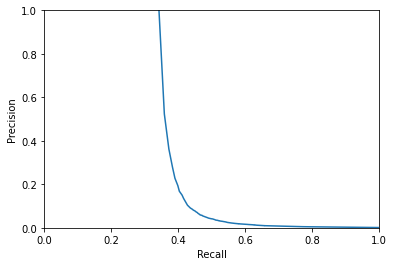

In [94]:
#print('TP:',tp_array)
#print('FP:',fp_array)
#print('FN:',fn_array)

precision = np.divide(tp_array,np.add(tp_array,fp_array))
recall = np.divide(tp_array,np.add(tp_array,fn_array))
#print('Precision:',precision)
#print('Recall:',recall)

# precision: TP / TP + FP
# recall: TP / TP + FN

plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.show